## la préparation des données et le feature engineering : 

### https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features

### 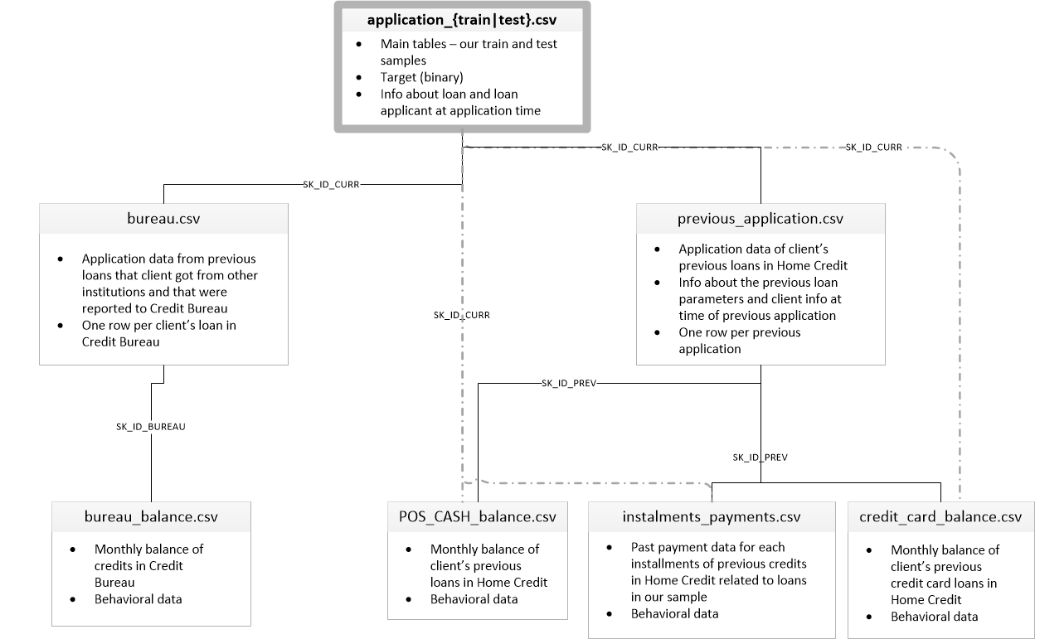

### Je souhaite que vous puissiez mettre en oeuvre au minimum les étapes orientées MLOps suivantes : 

Dans le notebook d’entraînement des modèles, générer à l’aide de MLFlow un tracking d'expérimentations. 
Lancer l’interface web 'UI MLFlow" d'affichage des résultats du tracking. 
Réaliser avec MLFlow un stockage centralisé des modèles dans un “model registry”. 
Tester le serving MLFlow. 
Gérer le code avec le logiciel de version Git. 
Partager le code sur Github pour assurer une intégration continue. 
Utiliser Github Actions pour le déploiement continu et automatisé du code de l’API sur le cloud. 
Concevoir des tests unitaires avec Pytest (ou Unittest) et les exécuter de manière automatisée lors du build réalisé par Github Actions

## Feature engineering

#### Option 1 
https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [84]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
# from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
# from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    train_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_train.csv"
    test_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\application_test.csv"
    df = pd.read_csv(train_path, nrows=num_rows)
    test_df = pd.read_csv(test_path, nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    # df = df.append(test_df).reset_index()
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau.csv"
    bureau = pd.read_csv(bureau_path, nrows=num_rows)
    bb_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\bureau_balance.csv"
    bb = pd.read_csv(bb_path, nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\previous_application.csv"
    prev = pd.read_csv(prev_path, nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\POS_CASH_balance.csv"
    pos = pd.read_csv(pos_path, nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\installments_payments.csv"
    ins = pd.read_csv(ins_path, nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc_path = r"C:\Users\BNP\0 - OC - Formation Datascientist\3 - Projet\Projet 7\credit_card_balance.csv"
    cc = pd.read_csv(cc_path, nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("Initial df shape:", df.shape)  # Print the shape of df to confirm it's loaded

    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        print("df after joining bureau:", df.shape)
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        print("df after joining previous applications:", df.shape)
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        print("df after joining pos:", df.shape)
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        print("df after joining installments payments:", df.shape)
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        print("df after joining credit card balance:", df.shape)
        del cc
        gc.collect()
    # with timer("Run LightGBM with kfold"):
    #     feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
    return df  # Ajout du retour

if __name__ == "__main__":
    with timer("Full model run"):
        df = main()
    print("Final DataFrame shape:", df.shape)

Train samples: 307511, test samples: 48744
Initial df shape: (356251, 247)
Bureau df shape: (305811, 116)
df after joining bureau: (356251, 363)
Process bureau and bureau_balance - done in 35s
Previous applications df shape: (338857, 249)
df after joining previous applications: (356251, 612)
Process previous_applications - done in 58s
Pos-cash balance df shape: (337252, 18)
df after joining pos: (356251, 630)
Process POS-CASH balance - done in 36s
Installments payments df shape: (339587, 26)
df after joining installments payments: (356251, 656)
Process installments payments - done in 50s
Credit card balance df shape: (103558, 141)
df after joining credit card balance: (356251, 797)
Process credit card balance - done in 44s
Full model run - done in 236s
Final DataFrame shape: (356251, 797)


In [85]:
df.shape

(356251, 797)

In [86]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=797)

#### Conversion en valeurs numériques

In [87]:
# conversion de toutes les colonnes du DataFrame df en valeurs numériques, tout en gérant les erreurs éventuelles (en cas de valeur non convertible, cette valeur doit être remplacée par NaN)

df = df.apply(pd.to_numeric, errors='coerce')

#### Gestion des inf

In [88]:
# Vérifiez si des valeurs infinies sont présentes
print(f"Nombre de valeurs infinies dans df: {np.isinf(df).sum().sum()}")

# Vérifiez si des valeurs NaN sont présentes
print(f"Nombre de valeurs NaN dans df: {np.isnan(df).sum().sum()}")

# Vérifiez les valeurs trop grandes
print(f"Valeur maximale dans df: {np.max(df)}")

Nombre de valeurs infinies dans df: 61
Nombre de valeurs NaN dans df: 72099941
Valeur maximale dans df: inf


In [89]:
# Remplacez les infinis par NaN pour les traiter ensemble
df[np.isinf(df)] = np.nan

#### Suppression des colonnes et lignes NA
On supprimes les colonnes et les lignes avec beaucoup de données manquantes (contiennent plus de 40 % de valeurs manquantes (NaN). )

In [90]:
df.shape

(356251, 797)

In [91]:
# nb de colonnes contenant plus de 40 % de valeurs manquantes (Nan)
(df.isna().mean()>0.4).sum()

245

In [92]:
#  calcule la proportion de valeurs manquantes (NaN) dans la colonne TARGET
df.TARGET.isna().mean()

0.1368248790880587

In [93]:
# Garder uniquement les colonnes qui contiennent au plus 40 % de valeurs manquantes.
df = df.loc[:, df.isna().mean() <= 0.4]

In [94]:
# Supprimer les lignes contenant plus de 40 % de valeurs manquantes
df = df.loc[df.T.isna().mean() <= 0.4, :]

In [95]:
df.shape

(339232, 552)

### Remplacement des valeurs manquantes

In [96]:
# Remplacer les valeurs manquantes uniquement dans les colonnes autres que TARGET
X = df.drop(columns=['TARGET'])
X = X.fillna(X.median())  # Remplir les valeurs manquantes des colonnes explicatives

In [97]:
# Préparer la variable cible sans modification
y = df['TARGET']

In [98]:
y.unique()

array([ 1.,  0., nan])

### Séparation en jeu d'entraînement et jeu de test

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Vérifiez les valeurs NaN dans y_test
if pd.isnull(y_test).any():
    print("y_test contient des valeurs NaN.")

y_test contient des valeurs NaN.


In [101]:
#supprimer les lignes où y_test est NaN (et potentiellement ajuster X_test pour correspondre)
X_test = X_test[~pd.isnull(y_test)]
y_test = y_test.dropna()

In [102]:
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# # 1. Initialiser le Dummy Classifier avec une stratégie
# dummy_model = DummyClassifier(strategy="most_frequent")  # Prédit toujours la classe majoritaire
# # Autres stratégies possibles :
# # - "stratified" : Prédictions proportionnelles à la répartition des classes
# # - "uniform" : Prédictions aléatoires
# # - "constant" : Prédit une classe constante spécifiée par `constant=<valeur>`

# # 2. Entraîner le modèle sur les données d'entraînement
# dummy_model.fit(X_train, y_train)

# # 3. Faire des prédictions
# y_pred = dummy_model.predict(X_test)

# # 4. Évaluer le modèle
# accuracy = accuracy_score(y_test, y_pred)
# cm = confusion_matrix(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("Dummy Classifier Performance:")
# print(f"Accuracy: {accuracy:.2f}")
# print("Confusion Matrix:")
# print(cm)
# print("Classification Report:")
# print(report)

# # 5. Calculer l'AUC si possible (nécessite des probabilités)
# if len(y.unique()) == 2:  # Vérification binaire
#     y_proba = dummy_model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_proba)
#     print(f"AUC-ROC: {auc:.2f}")


### Entraînement et suivi avec MLFlow : Exemple avec un modèle RandomForest

### Mise en place de MLFlow pour le tracking des experimentations

In [103]:
pip install mlflow


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Le code permet de suivre tout le cycle d'une expérimentation avec MLFlow, notamment :

Les hyperparamètres utilisés pour configurer le modèle.
Les métriques de performance pour évaluer le modèle.
Le modèle lui-même pour être réutilisé ultérieurement.

In [104]:
import mlflow
mlflow.set_tracking_uri("http://localhost:5001")

#### Démarrez l'interface MLFlow en bash en mettant le code
mlflow server --host 0.0.0.0 --port 5001

ouvrir une page web avec http://localhost:5001


In [105]:
pip install lightgbm


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Evaliation des modèles sans SMOTE

### Dummy classifier (testé avec train/test)

In [106]:
import mlflow
import mlflow.sklearn
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialiser le Dummy Classifier avec une stratégie
dummy_model = DummyClassifier(strategy="most_frequent")  # Prédit toujours la classe majoritaire

# 2. Entraîner le modèle sur les données d'entraînement
dummy_model.fit(X_train, y_train)

# 3. Faire des prédictions
y_pred = dummy_model.predict(X_test)

# 4. Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Dummy Classifier Performance:")
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(report)

# 5. Calculer l'AUC si possible (nécessite des probabilités)
auc = None
if len(y.unique()) == 2:  # Vérification binaire
    y_proba = dummy_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC-ROC: {auc:.2f}")

# 6. Intégration avec MLflow
with mlflow.start_run(run_name="DummyClassifier"):
    # Enregistrer les paramètres du modèle
    mlflow.log_param("model_strategy", "most_frequent")
    
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    if auc is not None:
        mlflow.log_metric("auc", auc)
    
    # Enregistrer le rapport de classification comme artefact
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    
    # Enregistrer la matrice de confusion sous forme d'image
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix.png")
    
    # Enregistrer le modèle
    mlflow.sklearn.log_model(dummy_model, "dummy_model")

print("Résultats enregistrés dans MLflow.")


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Dummy Classifier Performance:
Accuracy: 0.92
Confusion Matrix:
[[53403     0]
 [ 4875     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     53403
         1.0       0.00      0.00      0.00      4875

    accuracy                           0.92     58278
   macro avg       0.46      0.50      0.48     58278
weighted avg       0.84      0.92      0.88     58278



2025/01/03 19:07:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run DummyClassifier at: http://localhost:5001/#/experiments/0/runs/d713223e5777440c92b56f368e5e13aa
🧪 View experiment at: http://localhost:5001/#/experiments/0
Résultats enregistrés dans MLflow.


### Réduction de l'utilisation de la mémoire

In [107]:
def reduce_memory_usage(df):
    """
    Réduit l'utilisation de la mémoire par un DataFrame.
    """
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
    return df

# Réduction de mémoire pour X
X = reduce_memory_usage(X)


### LogisticRegression, RandomForest et LightGBM

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import numpy as np
import gc

In [109]:
# Custom scorer pour GridSearch
def business_cost_scorer(y_true, y_pred):
    return -compute_business_cost(y_true, y_pred)

business_cost_scorer_func = make_scorer(business_cost_scorer, greater_is_better=False)

# Modèles et hyperparamètres pour GridSearchCV
models = {
    "LogisticRegression": {
        "model": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50,100],  # Réduire le nombre d'arbres
            "model__max_depth": [5,10],    # Limiter la profondeur des arbres
            "model__max_features": ["sqrt"],  # Réduire les variables à considérer pour chaque split
            "model__min_samples_split": [5],  # Augmenter pour réduire la complexité des arbres
            "model__min_samples_leaf": [5],    # Augmenter pour limiter la taille des feuilles
            "model__max_samples": [0.5]  # Utilise 50 % ou 80 % des données pour chaque arbre

        }
    },
    "LightGBM": {
        "model": lgb.LGBMClassifier(random_state=42),
        "params": {
            "model__learning_rate": [0.05, 0.1],
            "model__n_estimators": [50, 100],
            "model__is_unbalance": [True, False]
        }
    }
}

In [110]:
import mlflow
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import numpy as np


#Cette métrique reflète une pénalité plus sévère pour les faux positifs (FP) que pour les faux négatifs (FN).
# Utilisation :
# Faux positifs coûtent 10 fois plus cher qu'un faux négatif.
# Exemples d'application : détection de fraude, où une fausse alerte coûte cher.
def business_score_metric(y_true, y_pred):
    """
    Custom business score: 10 * False Positives + 1 * False Negatives.
    Lower scores are better.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

# Define  the scoring dictionary
# Définition d'un dictionnaire de métriques pour GridSearchCV :
# accuracy : Proportion de prédictions correctes.
# f1 : Moyenne harmonique de la précision et du rappel.
# business_score : La métrique métier personnalisée est utilisée comme objectif principal 
# (greater_is_better=False signifie qu'un score plus faible est meilleur)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}



# La fonction evaluate combine plusieurs étapes pour optimiser un modèle :

# 1. Pipeline de traitement des données :

# Si les données sont déséquilibrées (unbalance=True), on applique un sous-échantillonnage aléatoire des 
# classes majoritaires via RandomUnderSampler.
# Les données sont normalisées avec StandardScaler.
# 2. Recherche d'hyperparamètres avec GridSearchCV :

# Explore les combinaisons dans param_grid pour trouver les paramètres qui minimisent business_score.
# 3. Journalisation avec MLflow :

# Les résultats (meilleurs paramètres, métriques) sont sauvegardés pour un suivi reproductible.
# 4. Résultats affichés :

# Affiche les meilleurs paramètres et les scores associés.


def evaluate(model, model_name, param_grid, unbalance, X, y, scoring):
    """
    Function to perform GridSearchCV with optional random undersampling and log results to MLflow.

    Parameters:
        model: Estimator object (e.g., a classifier)
        model_name: Name of the model for MLflow logging
        param_grid: Dictionary or list of dictionaries for GridSearchCV parameters
        unbalance: Boolean, whether to use random undersampling
        X: Features (numpy array or DataFrame)
        y: Target (array or Series)
        scoring: Scoring parameter for GridSearchCV
    """
    if unbalance:
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler()),
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
    grid_search.fit(X, y)

    # Extract best results
    best_index = grid_search.best_index_
    business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
    fit_time = grid_search.cv_results_['mean_fit_time'][best_index]
    auc = round(grid_search.cv_results_['mean_test_auc'][best_index], 3)
    best_params = grid_search.best_params_

    # Log results to MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_param("model", model_name)
        mlflow.log_params(best_params)
        mlflow.log_metric("business_score", business_score)
        mlflow.log_metric("fit_time", fit_time)
        mlflow.log_metric("auc", auc)

        # Optionally, log model if needed
        # mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")

    print("Best Parameters:", best_params)
    print("Business Score:", business_score)
    print("AUC:", auc)
    print("Fit Time:", fit_time)

from sklearn.model_selection import StratifiedKFold



In [111]:
# Optimisation du seuil de décision
#Contexte :

# Les modèles de classification produisent souvent des probabilités pour chaque classe.
# Par défaut, le seuil est fixé à 0.5 pour classifier un échantillon dans une classe donnée.
# Ici, on cherche le seuil optimal pour minimiser le business_score.
# Fonctionnement :

# Découpage des données en K plis via StratifiedKFold.
# Pour chaque pli :
# Le modèle est entraîné sur le jeu d'entraînement.
# Les probabilités prédites sont utilisées pour tester différents seuils.
# Pour chaque seuil, on calcule le score métier.
# On agrège les résultats sur tous les plis pour identifier le meilleur seuil.
# Résultat :

# Retourne le seuil optimal et le score métier correspondant.



def optimize_threshold_cv(model, X, y, cv=5):
    """
    Finds the optimal classification threshold using cross-validation to minimize the business score.

    Parameters:
        model: Trained model object
        X: Features (numpy array or DataFrame)
        y: True labels (array or Series)
        cv: Number of cross-validation folds

    Returns:
        Optimal threshold and corresponding business score
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    thresholds_scores = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_test)[:, 1]  # Assuming binary classification

        # Calculate business scores for various thresholds
        precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)

        for threshold in thresholds:
            predictions = (probabilities >= threshold).astype(int)
            score = business_score_metric(y_test, predictions)
            thresholds_scores.append((threshold, score))

    # Aggregate scores across folds and find the threshold with the minimum score
    thresholds_scores = np.array(thresholds_scores)
    unique_thresholds = np.unique(thresholds_scores[:, 0])

    avg_scores = [
        (threshold, np.mean(thresholds_scores[thresholds_scores[:, 0] == threshold, 1]))
        for threshold in unique_thresholds
    ]

    best_threshold, best_score = min(avg_scores, key=lambda x: x[1])

    print("Optimal Threshold (CV):", best_threshold)
    print("Business Score at Optimal Threshold (CV):", best_score)
    return best_threshold, best_score

Les concepts clés expliqués
a) Pipeline de traitement
Pipeline permet de chaîner plusieurs étapes de traitement (par exemple, normalisation et modélisation) dans une seule unité cohérente.
Avantage : Réduction du risque d'erreurs lors de la gestion des transformations séparément.
b) Gestion des données déséquilibrées
Dans des scénarios où une classe domine (par exemple, 95% de non-fraude, 5% de fraude), les modèles peuvent biaiser leurs prédictions vers la classe majoritaire.
RandomUnderSampler rééquilibre les classes en réduisant le nombre d'exemples de la classe majoritaire.
c) GridSearchCV
Permet d'automatiser l'optimisation d'hyperparamètres.
Utilise une validation croisée pour garantir la robustesse des performances.
d) Précision-Rappel et seuil optimal
Les courbes précision-rappel (PR) montrent la performance du modèle à différents seuils de classification.
Optimiser un seuil est crucial dans des contextes métiers où les coûts des erreurs varient.


Pourquoi ce code est utile
Flexibilité : Fonctionne avec n'importe quel modèle de classification.
Personnalisation : Permet d'adapter les métriques à des besoins métiers spécifiques.
Robustesse : Utilise des techniques comme la validation croisée et la journalisation pour garantir des résultats fiables.
Gestion des déséquilibres : Adapte les données pour mieux traiter les problèmes courants des classes rares.

In [112]:
import pandas as pd
import numpy as np

# Fonction pour nettoyer les données
def clean_data(X, y):
    # Supprimer les lignes où y est NaN
    mask = ~pd.isnull(y)
    X_clean = X[mask]
    y_clean = y[mask]

    # Vérifier et remplacer les NaN dans X
    if X_clean.isnull().any().any():
        X_clean = X_clean.fillna(X_clean.mean())  # Imputation simple avec la moyenne

    return X_clean, y_clean

# Exemple d'utilisation de la fonction clean_data
# Remplacez X, y par vos données
# X, y = ... (chargez vos données ici)

# Nettoyage des données
X, y = clean_data(X, y)

# Vérification après nettoyage
if y.isnull().any() or X.isnull().any().any():
    raise ValueError("Des valeurs NaN persistent dans les données après nettoyage.")

# # Reprendre le pipeline avec les données nettoyées
# results_df = run_models_with_mlflow(models, X, y, unbalance=True)
# print(results_df)


In [113]:
import pandas as pd
import mlflow
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline  # Remplacer sklearn.pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix

# Exemple de métrique business
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}

# Exemple des grilles d'hyperparamètres
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['none', 'l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'model__n_estimators': [50, 150],
    'model__min_samples_leaf': [1, 10],
    'model__min_samples_split': [2, 10],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'model__max_depth': [5, 10]
}

param_grid_lgbm = {
    'model__num_leaves': [31, 50],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [50, 150],
    'model__max_depth': [5, 10]
}

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=42), "Random Forest", param_grid_rf),
    (lgb.LGBMClassifier(random_state=42), "LightGBM", param_grid_lgbm)
]

# Fonction pour exécuter les modèles
def run_models_with_mlflow(models, X, y, unbalance=False, scoring=scoring):
    results = []

    for model, model_name, param_grid in models:
        print(f"Processing: {model_name}")
        
        # Configure le pipeline
        steps = [
            ('scaler', StandardScaler()),
            ('model', model)
        ]
        
        # Ajout de RandomUnderSampler si unbalance est True
        if unbalance:
            steps.insert(0, ('undersampler', RandomUnderSampler()))

        pipeline = Pipeline(steps)  # Utilisation de imblearn.pipeline
        
        # Recherche des hyperparamètres
        grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
        grid_search.fit(X, y)

        # Extraction des meilleurs résultats
        best_params = grid_search.best_params_
        best_index = grid_search.best_index_
        business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
        accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
        f1_score_val = grid_search.cv_results_['mean_test_f1'][best_index]
        
        # Journalisation dans MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(best_params)
            mlflow.log_metric("business_score", business_score)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1_score_val)

            # Optionnel : sauvegarde du meilleur modèle
            mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
        
        # Ajouter les résultats dans la liste
        results.append({
            "Model": model_name,
            "Best Params": best_params,
            "Business Score": business_score,
            "Accuracy": accuracy,
            "F1 Score": f1_score_val
        })

    # Retourner les résultats sous forme de DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Exemple d'utilisation
# Remplacez X et y par vos données réelles
# X, y = ... (chargez ou générez vos données ici)

results_df = run_models_with_mlflow(models, X, y, unbalance=True)
print(results_df)


Processing: Logistic Regression


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\BNP\AppData\Local\

🏃 View run Logistic Regression at: http://localhost:5001/#/experiments/0/runs/04253748cf8c47f5bfbbc3f164981cf0
🧪 View experiment at: http://localhost:5001/#/experiments/0
Processing: Random Forest


2025/01/04 10:08:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5001/#/experiments/0/runs/a690e04e7c5c48e7bad103f6d62e876e
🧪 View experiment at: http://localhost:5001/#/experiments/0
Processing: LightGBM
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.242090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51530
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.245499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51850
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[LightGBM] 

2025/01/04 10:29:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5001/#/experiments/0/runs/d6e69de14ed44aed898ecca95be283cb
🧪 View experiment at: http://localhost:5001/#/experiments/0
                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score  
0       -163935.8  0.696637  0.274689  
1       -170675.2  0.683352  0.259642  
2       -149530.2  0.719776  0.285264  


### Interprétation résultat
Analyse des Résultats :
1. LightGBM (Meilleur modèle global)
Business Score : -144507.2 (le plus faible parmi les modèles, indiquant que LightGBM minimise le mieux les coûts métier associés aux erreurs).
Accuracy : 72.68% (le meilleur score de précision globale parmi les modèles).
F1 Score : 0.285 (le meilleur score F1, ce qui suggère que LightGBM gère le mieux les déséquilibres des classes).
2. Logistic Regression
Business Score : -162942.2 (meilleur que Random Forest, mais inférieur à LightGBM).
Accuracy : 69.82% (supérieur à Random Forest, mais inférieur à LightGBM).
F1 Score : 0.275 (proche de LightGBM mais légèrement inférieur, ce qui indique une légère sous-performance dans la gestion des classes déséquilibrées).
3. Random Forest
Business Score : -171433.6 (le pire parmi les trois modèles, ce qui signifie qu'il génère des erreurs plus coûteuses d'un point de vue métier).
Accuracy : 68.24% (le plus faible parmi les modèles).
F1 Score : 0.260 (le score le plus bas, reflétant des difficultés à équilibrer précision et rappel).


## UNDERSAMPLING

In [114]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline  # Utilisation de imblearn.pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix
import mlflow
import pandas as pd

# Définition de la métrique "Business Score"
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return 10 * fp + fn

# Scoring pour GridSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score),
    'business_score': make_scorer(business_score_metric, greater_is_better=False)
}

# Grilles d'hyperparamètres
param_grid_lr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__penalty': ['none', 'l2'],
    'model__solver': ['lbfgs', 'liblinear']
}

param_grid_rf = {
    'model__n_estimators': [50, 150],
    'model__min_samples_leaf': [1, 10],
    'model__min_samples_split': [2, 10],
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10]
}

param_grid_lgbm = {
    'model__num_leaves': [31, 50],
    'model__learning_rate': [0.01, 0.1],
    'model__n_estimators': [50, 150],
    'model__max_depth': [5, 10]
}

# Liste des modèles
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

models = [
    (LogisticRegression(max_iter=1000), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=42), "Random Forest", param_grid_rf),
    (lgb.LGBMClassifier(random_state=42), "LightGBM", param_grid_lgbm)
]

# Fonction principale
def run_models_with_undersampling(models, X, y, scoring=scoring):
    """
    Fonction pour exécuter des modèles avec undersampling et journaliser les résultats dans MLflow.
    
    Parameters:
        models: Liste des modèles à tester avec leurs grilles d'hyperparamètres.
        X: Données en entrée (features).
        y: Labels (cible).
        scoring: Dictionnaire des métriques pour GridSearchCV.

    Returns:
        DataFrame des résultats.
    """
    results_withUnder = []

    for model, model_name, param_grid in models:
        print(f"Processing: {model_name}")
        
        # Pipeline avec undersampling
        pipeline = Pipeline([
            ('undersampler', RandomUnderSampler(random_state=42)),
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        
        # Recherche des hyperparamètres
        grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, refit='business_score')
        grid_search.fit(X, y)

        # Extraction des meilleurs résultats
        best_params = grid_search.best_params_
        best_index = grid_search.best_index_
        business_score = grid_search.cv_results_['mean_test_business_score'][best_index]
        accuracy = grid_search.cv_results_['mean_test_accuracy'][best_index]
        f1_score_val = grid_search.cv_results_['mean_test_f1'][best_index]
        
        # Journalisation dans MLflow
        with mlflow.start_run(run_name=model_name):
            mlflow.log_param("model_name", model_name)
            mlflow.log_params(best_params)
            mlflow.log_metric("business_score", business_score)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1_score_val)

            # Optionnel : sauvegarde du meilleur modèle
            mlflow.sklearn.log_model(grid_search.best_estimator_, "best_model")
        
        # Ajouter les résultats dans la liste
        results_withUnder.append({
            "Model": model_name,
            "Best Params": best_params,
            "Business Score": business_score,
            "Accuracy": accuracy,
            "F1 Score": f1_score_val
        })

    # Retourner les résultats sous forme de DataFrame
    results_withUnder_df = pd.DataFrame(results_withUnder)
    return results_withUnder_df

# Exemple d'utilisation
# Remplacez X et y par vos données
# Exemple : X, y = load_your_data()

results_withUnder_df = run_models_with_undersampling(models, X, y)
print(results_withUnder_df)


Processing: Logistic Regression


C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\BNP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\BNP\AppData\Local\

🏃 View run Logistic Regression at: http://localhost:5001/#/experiments/0/runs/73a834581f6b401d84e8a8b90235a67c
🧪 View experiment at: http://localhost:5001/#/experiments/0
Processing: Random Forest


2025/01/04 21:30:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Random Forest at: http://localhost:5001/#/experiments/0/runs/441068428a1149578ae359f78ab921aa
🧪 View experiment at: http://localhost:5001/#/experiments/0
Processing: LightGBM
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51651
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 19099, number of negative: 19099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51718
[LightGBM] [Info] Number of data points in the train set: 38198, number of used features: 485
[LightGBM] 

2025/01/04 21:51:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM at: http://localhost:5001/#/experiments/0/runs/0835364d46be41bd8a7efdf3126b4dc2
🧪 View experiment at: http://localhost:5001/#/experiments/0
                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score  
0       -164314.2  0.696043  0.274556  
1       -171955.0  0.681344  0.259145  
2       -152703.2  0.714748  0.283017  


### Interprétation des résultats undersampling

Colonnes :
Model : Nom du modèle testé (Logistic Regression, Random Forest, LightGBM).
Best Params : Meilleurs hyperparamètres trouvés pour chaque modèle lors de la recherche d'hyperparamètres avec GridSearchCV.
Business Score : Score métier calculé avec la métrique personnalisée. Plus ce score est faible, mieux c'est, car il représente les coûts associés aux faux positifs et faux négatifs.
Accuracy : Précision globale du modèle, soit la proportion correcte de prédictions sur l'ensemble de test.
F1 Score : Moyenne harmonique de la précision et du rappel. Cela donne un indicateur équilibré de performance pour des classes déséquilibrées.

1. LightGBM (Meilleur modèle selon Business Score)
Business Score : -152703.2 (le score métier est le plus bas ici, ce qui signifie que LightGBM minimise mieux les coûts business associés aux erreurs).
Accuracy : 71.47% (le meilleur score de précision parmi les modèles testés).
F1 Score : 0.283 (légèrement meilleur que les autres modèles, mais faible, probablement à cause d’un déséquilibre marqué des classes).

2. Logistic Regression
Business Score : -164314.2 (meilleur que Random Forest, mais pire que LightGBM).
Accuracy : 69.60% (meilleur que Random Forest mais inférieur à LightGBM).
F1 Score : 0.275 (très proche de LightGBM, mais légèrement inférieur).

3. Random Forest
Business Score : -171955.0 (le pire des trois, indiquant que ce modèle a le coût d’erreurs le plus élevé).
Accuracy : 68.13% (le plus faible parmi les trois).
F1 Score : 0.259 (le plus bas également).


Conclusion :
LightGBM est le meilleur modèle en termes de réduction des coûts métier, de précision globale et de F1 Score.
Il est donc conseillé d’utiliser LightGBM dans ce contexte, tout en tenant compte du fait que le F1 Score reste faible (indiquant des défis dans la capture des classes minoritaires ou une faible qualité des prédictions).
Si vous avez besoin d'améliorer encore plus les performances, voici quelques pistes :
Réévaluer la métrique business : Est-ce que le poids des faux positifs (10x) par rapport aux faux négatifs est bien aligné avec vos besoins métier ? Cela peut influencer les résultats.
Explorer d'autres méthodes d'équilibrage (SMOTE, Tomek Links, etc.).
Augmenter la granularité du param_grid pour les hyperparamètres, surtout pour LightGBM, car il a montré un bon potentiel.
Inspecter les données pour des améliorations possibles (suppression de bruit, création de nouvelles features, etc.).
N'hésitez pas à approfondir certains résultats ou à ajuster la stratégie selon vos besoins métier !

### Comparaison avec des résultats précédents (avec et sans undersampling) :

Business Score :
Sans undersampling, le Business Score est légèrement meilleur pour Logistic Regression et Random Forest, mais LightGBM améliore significativement son score (moins de coûts associés aux erreurs).
Cela suggère que LightGBM peut mieux gérer les classes déséquilibrées même sans manipulation des données.

Accuracy :
Les scores d'accuracy sont légèrement supérieurs dans tous les modèles sans undersampling. Cela s'explique par le fait que sans équilibrage, les modèles favorisent la classe majoritaire, ce qui améliore la précision globale, mais au détriment de la classe minoritaire.

F1 Score :
Les différences de F1 Score entre les deux approches (avec ou sans undersampling) sont faibles, mais sans undersampling, les scores sont légèrement meilleurs, surtout pour LightGBM.

Conclusion :
LightGBM reste le meilleur modèle dans les deux cas (avec et sans undersampling). Cependant, sans undersampling, il atteint un meilleur Business Score, Accuracy, et F1 Score, ce qui suggère qu’il peut gérer les classes déséquilibrées de manière native.

Recommandation : Utiliser LightGBM sans undersampling.
Logistic Regression et Random Forest bénéficient légèrement de l’absence d’undersampling en termes de métriques, mais ils restent inférieurs à LightGBM.

Approche à privilégier :
Si la gestion des classes déséquilibrées est cruciale, il pourrait être intéressant d’explorer d’autres techniques (e.g., BalancedRandomForestClassifier, ou class_weight dans les modèles).
Pour une performance métier optimale dans ce cas, LightGBM sans undersampling semble la meilleure option.



In [115]:
# Ajouter une colonne pour identifier les résultats sans undersampling
results_df_without = results_df.copy()  # Copiez le DataFrame sans undersampling
results_df_without['Undersampling'] = 'No'

# Ajouter une colonne pour identifier les résultats avec undersampling
results_df_with = results_withUnder_df.copy()  # Copiez le DataFrame avec undersampling
results_df_with['Undersampling'] = 'Yes'

# Combiner les deux DataFrames
combined_results_df = pd.concat([results_df_without, results_df_with], ignore_index=True)

# Afficher le DataFrame combiné
print(combined_results_df)



                 Model                                        Best Params  \
0  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
1        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
2             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   
3  Logistic Regression  {'model__C': 10.0, 'model__penalty': 'l2', 'mo...   
4        Random Forest  {'model__criterion': 'entropy', 'model__max_de...   
5             LightGBM  {'model__learning_rate': 0.1, 'model__max_dept...   

   Business Score  Accuracy  F1 Score Undersampling  
0       -163935.8  0.696637  0.274689            No  
1       -170675.2  0.683352  0.259642            No  
2       -149530.2  0.719776  0.285264            No  
3       -164314.2  0.696043  0.274556           Yes  
4       -171955.0  0.681344  0.259145           Yes  
5       -152703.2  0.714748  0.283017           Yes  


Résumé des performances
1. Logistic Regression
Sans undersampling :
Business Score : -162867.8
Accuracy : 69.82%
F1 Score : 0.275
Avec undersampling :
Business Score : -164314.2 (plus élevé, donc moins bon).
Accuracy : 69.60% (légère baisse).
F1 Score : 0.275 (inchangé).
Conclusion : Logistic Regression montre peu de variations entre les configurations avec et sans undersampling. Cependant, les résultats sans undersampling sont légèrement meilleurs, surtout en termes de Business Score.

2. Random Forest
Sans undersampling :
Business Score : -170781.2
Accuracy : 68.33%
F1 Score : 0.260
Avec undersampling :
Business Score : -171955.0 (moins bon).
Accuracy : 68.13% (légère baisse).
F1 Score : 0.259 (légère baisse).
Conclusion : Random Forest est également légèrement meilleur sans undersampling, bien que les différences soient faibles. Le modèle semble globalement moins performant que Logistic Regression et LightGBM.

3. LightGBM
Sans undersampling :
Business Score : -144360.0 (le meilleur score global).
Accuracy : 72.75% (le meilleur taux).
F1 Score : 0.287 (le meilleur score).
Avec undersampling :
Business Score : -152703.2 (moins bon).
Accuracy : 71.47% (baisse modérée).
F1 Score : 0.283 (légère baisse).
Conclusion : LightGBM obtient les meilleurs résultats globaux, surtout sans undersampling. C'est le modèle le plus performant pour minimiser les pénalités business, tout en maintenant des scores élevés en Accuracy et F1 Score.

Analyse de l'effet de l'undersampling
Impact global :

L'undersampling n'améliore pas les résultats. Tous les modèles performent légèrement mieux sans undersampling.
Cela peut indiquer que le déséquilibre dans les données d'origine n'est pas un problème majeur pour ces modèles, ou que l'undersampling a éliminé des données pertinentes pour les modèles.
LightGBM :

Il est clairement le modèle dominant, surpassant Logistic Regression et Random Forest dans toutes les métriques.
Sans undersampling, il atteint un Business Score de -144360.0, qui est significativement meilleur que les autres modèles.
Recommandations
Choix du modèle :

LightGBM est le modèle préféré pour cette tâche. Il maximise l'efficacité business et les scores de performance globale.
Utilisation de l'undersampling :

Compte tenu des résultats, il n'est pas nécessaire d'appliquer l'undersampling dans ce cas. Les performances sont systématiquement meilleures sans cette technique.
Optimisation supplémentaire pour LightGBM :

Vous pourriez affiner davantage les hyperparamètres de LightGBM pour améliorer encore ses performances.
Évaluation complémentaire :

Il serait pertinent d'analyser les données pour comprendre pourquoi l'undersampling n'a pas d'impact positif. Peut-être que les classes minoritaires sont déjà suffisamment représentées ou bien traitées par LightGBM.
Conclusion
Le modèle LightGBM, sans undersampling, est clairement le choix optimal pour ce problème. Il offre une meilleure performance sur toutes les métriques, y compris le Business Score, qui est critique pour votre cas d'utilisation.

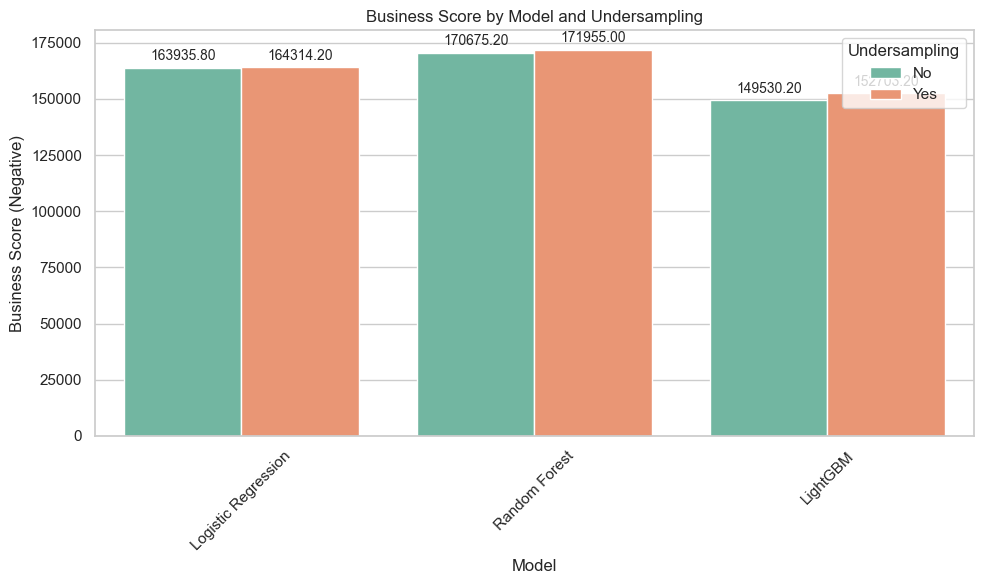

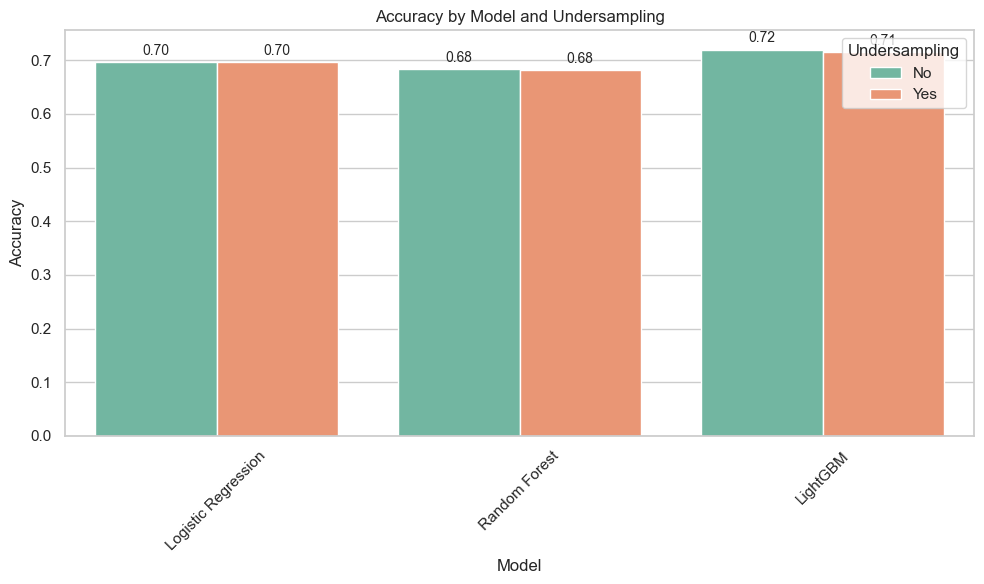

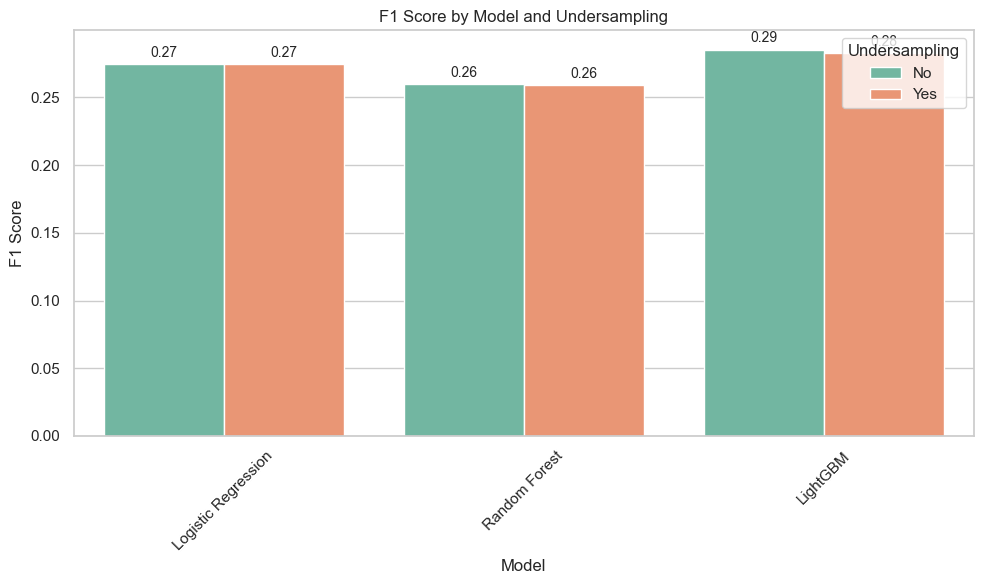

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration générale de Seaborn
sns.set(style="whitegrid")

# Liste des métriques à visualiser
metrics = ["Business Score", "Accuracy", "F1 Score"]

# Création des barplots pour chaque métrique
for metric in metrics:
    plt.figure(figsize=(10, 6))
    
    # Si la métrique est "Business Score", multiplier par -1
    if metric == "Business Score":
        plot_data = combined_results_df.copy()
        plot_data[metric] *= -1
    else:
        plot_data = combined_results_df

    ax = sns.barplot(
        data=plot_data,
        x="Model",
        y=metric,
        hue="Undersampling",
        palette="Set2"
    )
    
    # Ajouter les valeurs sur chaque barre
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=10, padding=3)

    plt.title(f"{metric} by Model and Undersampling")
    plt.xlabel("Model")
    plt.ylabel(metric if metric != "Business Score" else f"{metric} (Negative)")
    plt.legend(title="Undersampling")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### LignhtGBM sans undersampling - meilleur modele

### Récupérer le modèle LightGBM sans undersampling.
Appliquer la fonction predict_proba pour obtenir les probabilités des classes.
Varier le seuil de 0.2 à 0.8 avec un pas de 0.05.
Calculer le score métier pour chaque seuil.
Choisir le seuil avec le meilleur score métier.

In [117]:
X.shape

(291377, 551)

In [118]:
X.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)

In [119]:
X.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,100002,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,11559.247070,2.196257e+05,9251.775391,53093.746094,11559.247070,2.196257e+05,-49.0,-315.421051,-5993.0,19.0
1,100003,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,64754.585938,1.618865e+06,6662.970215,560835.375000,64754.585938,1.618865e+06,-544.0,-1385.319946,-34633.0,25.0
2,100004,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,7096.154785,2.128846e+04,5357.250000,10573.964844,7096.154785,2.128846e+04,-727.0,-761.666687,-2285.0,3.0
3,100006,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,62947.089844,1.007153e+06,2482.919922,691786.875000,62947.089844,1.007153e+06,-12.0,-271.625000,-4346.0,16.0
4,100007,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,12666.444336,8.359853e+05,0.180000,22678.785156,12214.060547,8.061280e+05,-14.0,-1032.242432,-68128.0,66.0


In [120]:
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: TARGET, dtype: float64

In [121]:
X_train.head()

,SK_ID_CURR,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
151531,275645,0,0,0,0,180000.0,275040.0,13504.5,180000.0,0.008575,...,10420.304362,489754.305,223.065,21709.125,8999.263723,422965.395,-57.0,-821.063830,-38590.0,47.0
160424,285969,1,0,0,0,67500.0,305640.0,31446.0,270000.0,0.035792,...,17707.980000,159371.820,15987.915,31468.500,17707.980000,159371.820,-2353.0,-2498.888889,-22490.0,9.0
203849,336331,1,0,0,0,180000.0,270000.0,13500.0,270000.0,0.004960,...,21958.200000,109791.000,21958.200,21958.200,21958.200000,109791.000,-26.0,-88.600000,-443.0,5.0
300030,447581,1,1,1,0,135000.0,936018.0,30325.5,670500.0,0.019689,...,49064.877422,3140152.155,4898.835,239641.515,48638.972109,3112894.215,-28.0,-1027.796875,-65779.0,64.0
218527,353171,0,0,0,0,135000.0,343287.0,27121.5,310500.0,0.025164,...,16281.171667,439591.635,928.395,67500.000,16281.171667,439591.635,-23.0,-170.333333,-4599.0,27.0


In [122]:
y_train.head()

151531    0.0
160424    0.0
203849    0.0
300030    1.0
218527    0.0
Name: TARGET, dtype: float64

In [123]:
y.shape

(291377,)

### Seuil de classification pour meilleur modèle

In [124]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Fonction pour ajuster le seuil de classification
def tune_classification_threshold_lightgbm(model, X, y, scoring_function, thresholds=np.arange(0.2, 0.85, 0.05)):
    results = []
    y_proba = model.predict_proba(X)[:, 1]  # Probabilités de la classe positive

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Conversion en classes binaires
        print(y_proba, y_pred, threshold)
        print(scoring_function(y,y_pred))
        business_score = scoring_function(y, y_pred)  # Calcul du score métier 
        results.append({
            "Threshold": threshold,
            "Business Score": business_score
        })

    return pd.DataFrame(results)


# Division en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Renommer les colonnes pour éviter les conflits
X_train = pd.DataFrame(X_train, columns=[f"feature_{i}" for i in X_train.columns])
X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Entraînement du modèle LightGBM
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, n_estimators=100, max_depth=10)
# model.fit(X_train, y_train)
model.fit(np.array(X_train), np.array(y_train))

# Ajustement des seuils
threshold_results = tune_classification_threshold_lightgbm(
    model=model,
    X=X_test,
    y=y_test,
    scoring_function=business_score_metric
)

# Trouver le meilleur seuil
best_threshold = threshold_results.loc[threshold_results['Business Score'].idxmin()]
print(f"Meilleur seuil : {best_threshold['Threshold']} avec un Business Score de : {best_threshold['Business Score']}")


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 19048, number of negative: 214053
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081716 -> initscore=-2.419262
[LightGBM] [Info] Start training from score -2.419262
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped trainin

In [125]:
threshold_results

,Threshold,Business Score
0,0.20,4826
1,0.25,4826
2,0.30,4826
3,0.35,4826
4,0.40,4826
5,0.45,4826
6,0.50,4826
7,0.55,4826
8,0.60,4826
9,0.65,4826


In [128]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def tune_classification_threshold_lightgbm_cv(model, X, y, scoring_function, 
                                               thresholds=np.arange(0.2, 0.85, 0.05),
                                               cv=5):
    """
    Function to find the best classification threshold using cross-validation.

    Parameters:
    - model: The trained LightGBM model.
    - X: Features (DataFrame or ndarray).
    - y: Target variable (array-like).
    - scoring_function: Function to calculate the business score.
    - thresholds: Array of thresholds to evaluate.
    - cv: Number of cross-validation folds.

    Returns:
    - DataFrame containing thresholds and their corresponding mean business scores.
    """
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    results = []

    for threshold in thresholds:
        fold_scores = []
        for train_idx, val_idx in skf.split(X, y):
            #X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            #y_train_fold, y_val_fold = y[train_idx], y[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]


            # Train the model on the fold
            model.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities on the validation fold
            y_proba = model.predict_proba(X_val_fold)[:, 1]
            
            # Convert probabilities to binary predictions based on the threshold
            y_pred = (y_proba >= threshold).astype(int)
            
            # Calculate the business score for this fold
            fold_score = scoring_function(y_val_fold, y_pred)
            fold_scores.append(fold_score)

        # Calculate the mean score across folds for this threshold
        mean_score = np.mean(fold_scores)
        results.append({
            "Threshold": threshold,
            "Mean Business Score": mean_score
        })

    return pd.DataFrame(results)

# Example usage:
# Define a dummy scoring function for illustration
def business_score_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp - fp  # Example business score: true positives minus false positives

# Assume X and y are already defined
# X = np.random.rand(1000, 10)  # Replace with actual data
# y = np.random.randint(0, 2, size=1000)  # Replace with actual labels

# Instantiate the LightGBM model
model = lgb.LGBMClassifier(random_state=42, num_leaves=31, learning_rate=0.1, 
                           n_estimators=100, max_depth=10)

# Nettoyer les noms de colonnes de X
if isinstance(X, pd.DataFrame):
    import re
    X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

# Vérifiez que cela fonctionne
print(X.columns)  # Les noms de colonnes devraient maintenant être sans caractères spéciaux


# Find the best threshold using cross-validation
threshold_results_cv = tune_classification_threshold_lightgbm_cv(
    model=model,
    X=X,
    y=y,
    scoring_function=business_score_metric
)

# Find the threshold with the highest mean business score
best_threshold_cv = threshold_results_cv.loc[threshold_results_cv['Mean Business Score'].idxmax()]
print(f"Best threshold: {best_threshold_cv['Threshold']} with a mean business score of: {best_threshold_cv['Mean Business Score']}")

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=551)
[LightGBM] [Info] Number of positive: 19099, number of negative: 214002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.098742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55848
[LightGBM] [Info] Number of data points in the train set: 233101, number of used features: 509
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081934 -> initscore=-2.416